In [ ]:
!mamba install famsa t-coffee mmseqs2 -y -q
!pip install -q protein-bert tensorflow==2.10.*

In [1]:
from learnMSA import msa_hmm

2023-08-11 12:34:51.315706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 12:34:51.396372: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-11 12:34:51.411546: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-11 12:34:51.753366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

HMM training supported by protein embeddings:

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = msa_hmm.config.make_default(num_models)
config["batch_size"] = msa_hmm.config.get_adaptive_batch_size_with_language_model
# train a bit longer and with smaller updates than the default
config["use_language_model"] = True
config["learning_rate"] = 0.05
config["epochs"] = [10, 4, 20]
emission_init = [msa_hmm.initializers.EmbeddingEmissionInitializer() for _ in range(config["num_models"])]
if config["use_shared_embedding_insertions"]:
    insertion_init = [msa_hmm.initializers.EmbeddingEmissionInitializer() for _ in range(config["num_models"])]
else:
    insertion_init = [msa_hmm.initializers.make_default_insertion_init() for _ in range(config["num_models"])]
config["emitter"] = msa_hmm.emit.EmbeddingEmitter(config["lm_name"], 
                                        config["reduced_embedding_dim"],
                                        config["embedding_l2_match"], 
                                        config["embedding_l2_insert"], 
                                        emission_init=emission_init, 
                                        insertion_init=insertion_init,
                                        use_shared_embedding_insertions=config["use_shared_embedding_insertions"],
                                        frozen_insertions=config["frozen_insertions"],
                                        use_finetuned_lm=config["use_finetuned_lm"])
# we have to define a special model- and batch generator if using a language model
# because the emission probabilities are computed differently and the LM requires specific inputs
model_gen = msa_hmm.train.embedding_model_generator
batch_gen = msa_hmm.train.EmbeddingBatchGenerator(config["lm_name"], config["reduced_embedding_dim"], use_finetuned_lm=config["use_finetuned_lm"])
alignment_model = msa_hmm.align.run_learnMSA(train_filename,
                                              out_filename,
                                              config, 
                                              model_generator=model_gen,
                                              batch_generator=batch_gen,
                                              sequence_weights=msa_hmm.align.compute_sequence_weights(train_filename, "tmp"),
                                              verbose=True,
                                              align_insertions=True)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

2023-08-11 12:35:04.279275: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Fitting models of lengths [26 26 27 26 24 26 23 25 26 23] on 7774 sequences.
Batch size= 200 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.
Epoch 1/10


2023-08-11 12:38:40.931095: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5590d512f7c0


44/44 - 18s - loss: 126.7328 - loglik: -1.0722e+02 - logprior: -1.9516e+01 - 18s/epoch - 408ms/step
Epoch 2/10
44/44 - 3s - loss: 78.6779 - loglik: -7.3088e+01 - logprior: -5.5897e+00 - 3s/epoch - 73ms/step
Epoch 3/10
44/44 - 3s - loss: 73.1709 - loglik: -6.9593e+01 - logprior: -3.5774e+00 - 3s/epoch - 79ms/step
Epoch 4/10
44/44 - 3s - loss: 71.3087 - loglik: -6.8467e+01 - logprior: -2.8420e+00 - 3s/epoch - 79ms/step
Epoch 5/10
44/44 - 3s - loss: 70.4669 - loglik: -6.7972e+01 - logprior: -2.4945e+00 - 3s/epoch - 77ms/step
Epoch 6/10
44/44 - 4s - loss: 69.7970 - loglik: -6.7508e+01 - logprior: -2.2887e+00 - 4s/epoch - 82ms/step
Epoch 7/10
44/44 - 4s - loss: 69.4168 - loglik: -6.7279e+01 - logprior: -2.1383e+00 - 4s/epoch - 81ms/step
Epoch 8/10
44/44 - 4s - loss: 69.0564 - loglik: -6.7027e+01 - logprior: -2.0289e+00 - 4s/epoch - 80ms/step
Epoch 9/10
44/44 - 3s - loss: 68.8695 - loglik: -6.6930e+01 - logprior: -1.9400e+00 - 3s/epoch - 78ms/step
Epoch 10/10
44/44 - 3s - loss: 68.7112 - log

FAMSA (Fast and Accurate Multiple Sequence Alignment) 
  version 2.2.2- (2022-10-09)
  S. Deorowicz, A. Debudaj-Grabysz, A. Gudys

Done!
FAMSA (Fast and Accurate Multiple Sequence Alignment) 
  version 2.2.2- (2022-10-09)
  S. Deorowicz, A. Debudaj-Grabysz, A. Gudys

Done!


39/39 [==============================] - 3s 17ms/step
>l=-54.70_t=0.01
............$CD.......P......N............P........CYN.HG..T..CS........LR......A...T......................G.....YTCSCL....PR......YT....GEH$.......................
>l=-57.20_t=0.01
............$CD.......S......Q............P........CRN.-G..T..CSl.......NT......N...T......................D.....YTCACF....PG......YT....GRY$.......................
>l=-50.26_t=0.01
............$CD.......S......D............P........CLN.GG..T..CT........LR......Sl..D......................S.....YSCACA....PG......YT....GQH$.......................
>l=-63.30_t=0.01
............$CD.......H......V............T........CLN.GG..T..CQ........LK......Tl..E......................D.....YTCACA....NG......YT....GER$.......................
>l=-63.94_t=0.01
............$CD.......H......V............T........CLN.GG..T..CQ........LK......Tl..E......................E.....YTCACA....NG......YT....GDR$.......................
>l=-64.11_t=0.01
............$CD....

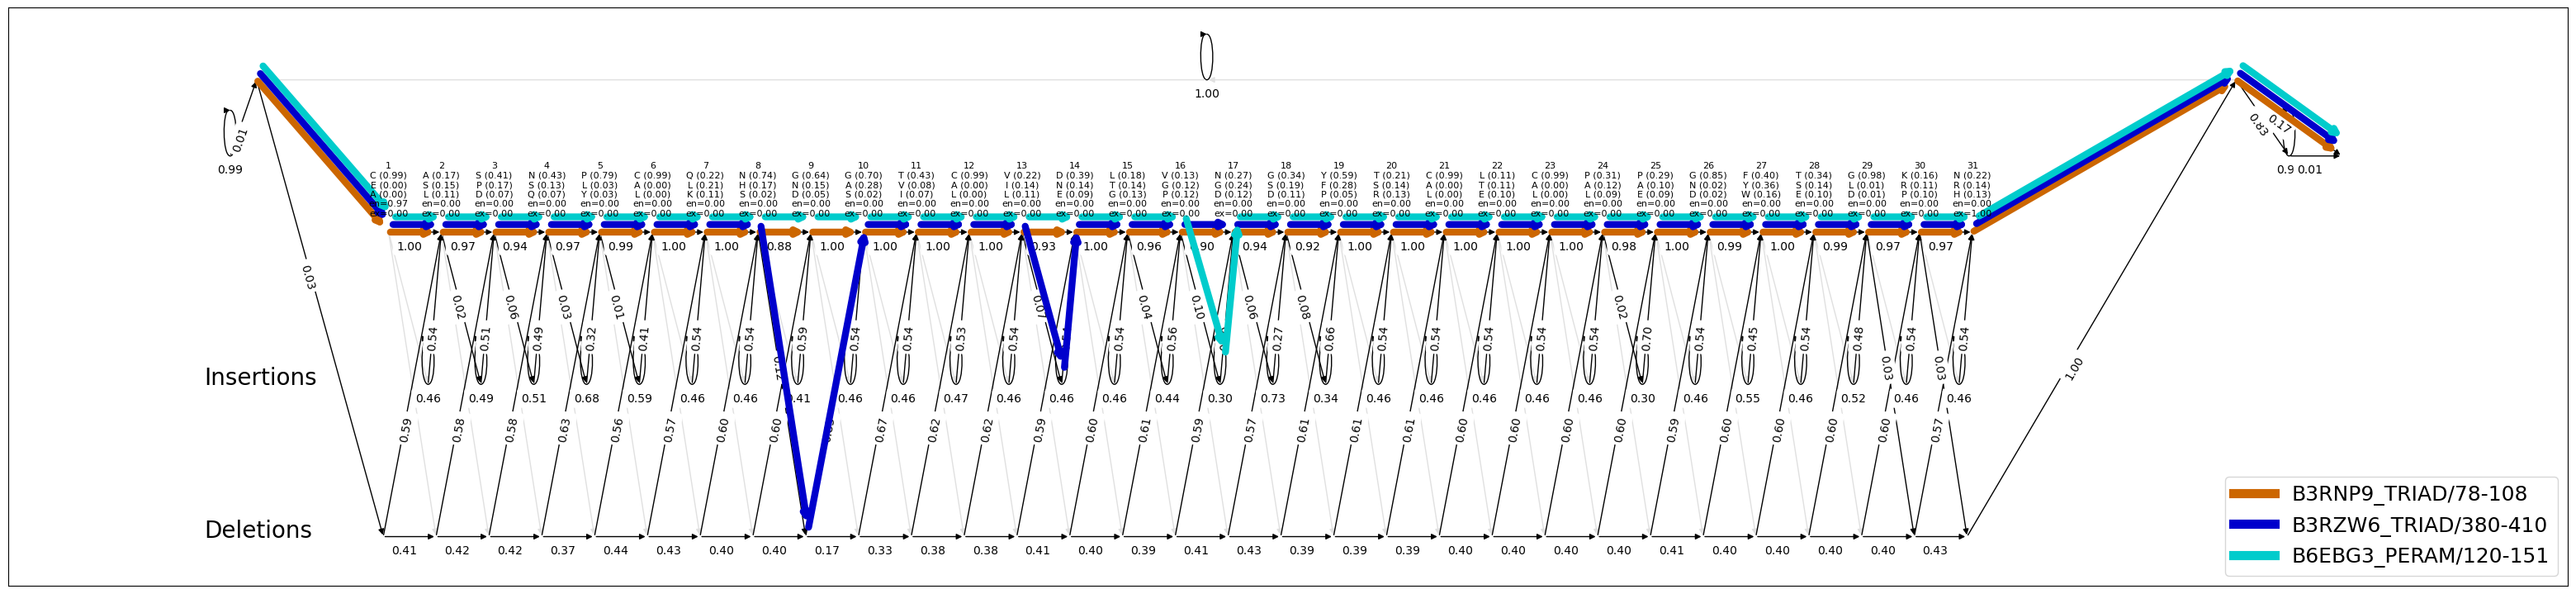

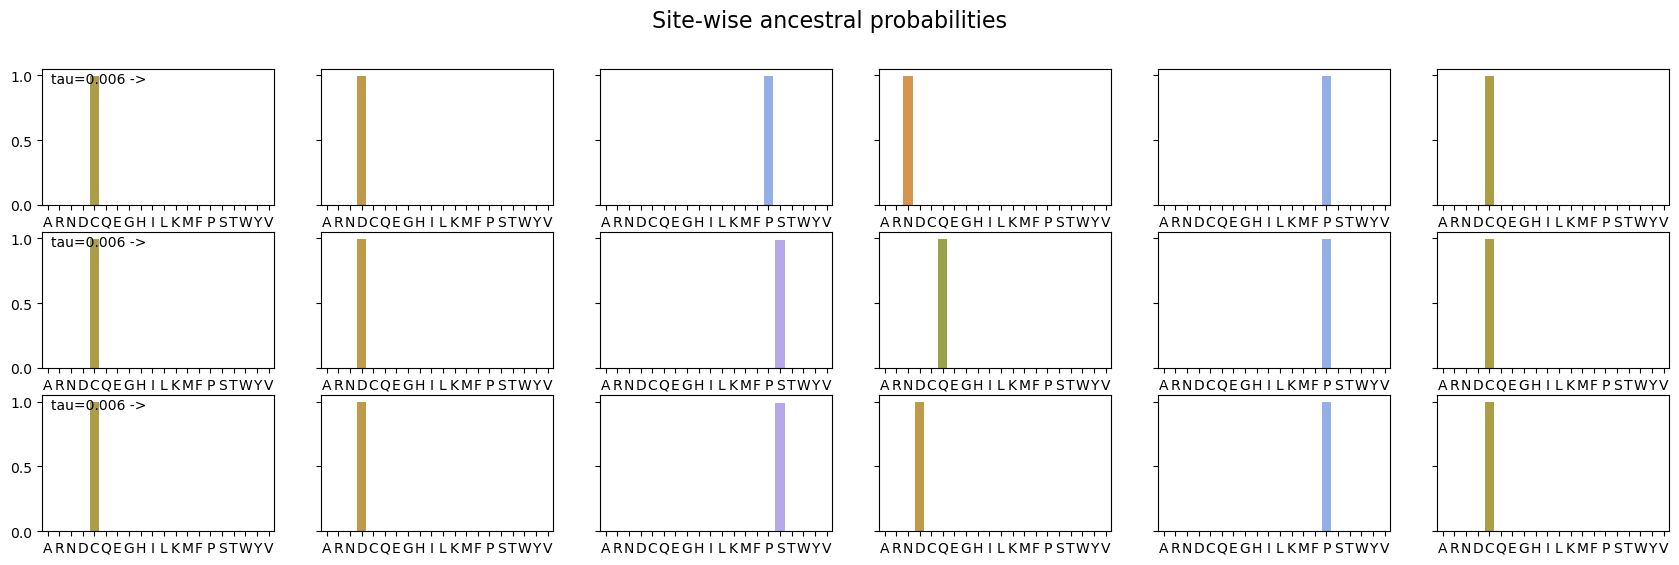

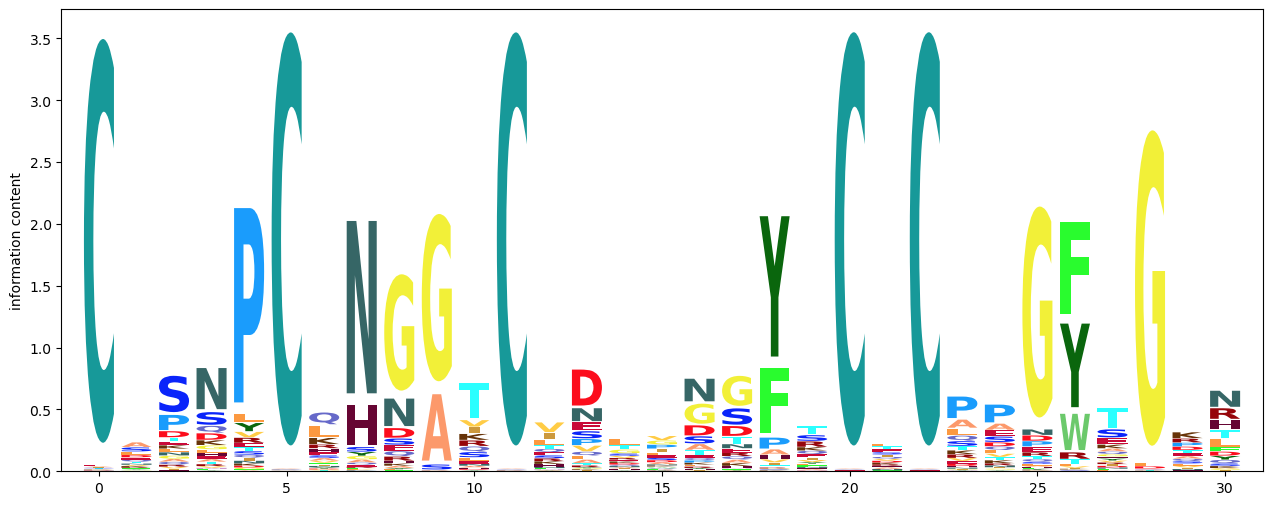

In [4]:
msa_hmm.vis.print_and_plot(alignment_model, alignment_model.best_model)

In [5]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [6]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    75.8 [100.0]   [ 5182]
